In [2]:
import os

import skimage.feature
import skimage.transform.hough_transform as ht
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from skimage.io import imread

In [3]:
import random


def random_color():
    return (random.random(), random.random(), random.random())

### Load images

In [4]:
folder_1 = "images_vol_1"
folder_2 = "images_vol_2"
images = []


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = imread(os.path.join(folder, filename))
            if img is not None:
                scaled_image = skimage.transform.resize(img, (img.shape[0] // 2, img.shape[1] // 2))
                img_bw = skimage.color.rgb2gray(scaled_image)
                images.append(img_bw)
    return images


def crop_image(img, border_size=10):
    return img[border_size:-border_size, border_size:-border_size]

In [5]:
images = load_images_from_folder(folder_1)

In [6]:
@widgets.interact(image_index=(0, len(images) - 1, 1))
def plot_images(image_index):
    plt.imshow(images[image_index], cmap="gray")

interactive(children=(IntSlider(value=10, description='image_index', max=20), Output()), _dom_classes=('widget…

## Edge detection

In [7]:
def edge_detection(images, sigma=2.5, low_threshold=0.1, high_threshold=0.3):
    imgs_edges = []

    for img in images:
        imgs_edges.append(
            skimage.feature.canny(img, low_threshold=low_threshold, high_threshold=high_threshold, sigma=sigma))
    return imgs_edges

In [8]:
# plot edges for each image with setting the threshold etc.
@widgets.interact(image_index=(0, len(images) - 1, 1), sigma=(0.1, 5, 0.1), low_threshold=(0, 1, 0.01),
                  high_threshold=(0, 1, 0.01))
def plot_edges(image_index, sigma=2.5, low_threshold=0.1, high_threshold=0.3):
    plt.imshow(edge_detection([images[image_index]], sigma=sigma, low_threshold=low_threshold,
                              high_threshold=high_threshold)[0])


interactive(children=(IntSlider(value=10, description='image_index', max=20), FloatSlider(value=2.5, descripti…

In [9]:
imgs_edges = edge_detection(images, sigma=2.5, low_threshold=0.1, high_threshold=0.3)

In [10]:
# imgs_edges = [crop_image(img) for img in imgs_edges]

In [11]:
@widgets.interact(image_index=(0, len(images) - 1, 1))
def plot_lines(image_index):
    plt.imshow(imgs_edges[image_index])

interactive(children=(IntSlider(value=10, description='image_index', max=20), Output()), _dom_classes=('widget…

## Hough transform

In [12]:
def find_lines(imgs_edges, threshold=15):
    lines_list = []
    for index, img_edges in enumerate(imgs_edges):
        # Perform Hough transform
        hspace, angles, dists = ht.hough_line(img_edges)

        # Find peaks in the Hough transform
        hspace_peaks, angles_peaks, dists_peaks = ht.hough_line_peaks(hspace, angles, dists, threshold=threshold)

        # Collect the lines
        lines = []
        for angle, dist in zip(angles_peaks, dists_peaks):
            p0 = (dist * np.cos(angle), dist * np.sin(angle))
            p1 = (p0[0] + 1000 * np.sin(angle), p0[1] - 1000 * np.cos(angle))
            lines.append((angle, dist, img_edges, np.array((*p0, 1)), np.array((*p1, 1))))
        lines_list.append(lines)
    return lines_list


# Example usage
imgs_lines = find_lines(imgs_edges, 100)

In [13]:
print(f'On average {np.mean([len(lines) for lines in imgs_lines]):.1f} lines per image')

On average 7.5 lines per image


In [14]:
# plot lines for each image
@widgets.interact(image_index=(0, len(images) - 1, 1))
def plot_lines(image_index):
    # Set the DPI (dots per inch)
    plt.imshow(imgs_edges[image_index])
    for angle, dist, _, p0, p1 in imgs_lines[image_index]:
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - imgs_edges[image_index].shape[1] * np.cos(angle)) / np.sin(angle)
        plt.plot(p0[0], p0[1], 'ro')
        plt.plot(p1[0], p1[1], 'ro')
        plt.plot((0, imgs_edges[image_index].shape[1]), (y0, y1), color="red")

interactive(children=(IntSlider(value=10, description='image_index', max=20), Output()), _dom_classes=('widget…

In [15]:
@widgets.interact(image_index=(0, len(images) - 1, 1))
def plot_lines(image_index):
    plt.imshow(imgs_edges[image_index])
    for angle, dist, edges, p0, p1 in imgs_lines[image_index]:
        # Find all pixels in the edge image that align with this line
        y_idxs, x_idxs = np.nonzero(edges)
        coords = []

        for x, y in zip(x_idxs, y_idxs):
            # Calculate rho for each (x, y) and check if it lies near the detected line
            rho = x * np.cos(angle) + y * np.sin(angle)
            if np.abs(rho - dist) < 2:  # Threshold tolerance for matching line points
                coords.append((x, y))

        # If we have points for this line, find the endpoints
        if coords:
            x_coords, y_coords = zip(*coords)
            plt.plot(x_coords, y_coords, '-r')  # Plot line segment in red

interactive(children=(IntSlider(value=10, description='image_index', max=20), Output()), _dom_classes=('widget…

In [16]:
# plot lines for each image
@widgets.interact(image_index=(0, len(images) - 1, 1))
def plot_points(image_index):
    lines = []
    plt.imshow(imgs_edges[image_index])
    for angle, dist, _, p0, p1 in imgs_lines[image_index]:
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - imgs_edges[image_index].shape[1] * np.cos(angle)) / np.sin(angle)
        color = random_color()
        plt.plot(p0[0], p0[1], 'o', color=color)
        plt.plot(p1[0], p1[1], 'o', color=color)
        lines.append((angle, dist, p0, p1))

interactive(children=(IntSlider(value=10, description='image_index', max=20), Output()), _dom_classes=('widget…

In [17]:
max_absolut_position = 2500


def line_intersections(imgs_lines):
    intersections = []
    for i in range(len(imgs_lines)):
        lines = []
        for _, _, _, p0, p1 in imgs_lines[i]:
            line = np.cross(p0, p1)
            lines.append(line)

        img_intersection = []
        for i in range(len(lines)):
            if i == len(lines) - 1:
                break
            for j in range(i + 1, len(lines) - 1):
                e = np.cross(lines[i], lines[j])
                e_cart = e / e[2]
                if np.abs(e_cart[0]) < max_absolut_position and np.abs(e_cart[1]) < max_absolut_position:
                    img_intersection.append(e)
        intersections.append(img_intersection)
    return intersections


imgs_intersections = line_intersections(imgs_lines)

/var/folders/ft/p6xwtlq12ygfhmnytl1ngxdm0000gn/T/ipykernel_7292/2592067629.py:18: RuntimeWarning: divide by zero encountered in divide
  e_cart = e / e[2]
/var/folders/ft/p6xwtlq12ygfhmnytl1ngxdm0000gn/T/ipykernel_7292/2592067629.py:18: RuntimeWarning: invalid value encountered in divide
  e_cart = e / e[2]


In [18]:
# plot intersection points
@widgets.interact(image_index=(0, len(images) - 1, 1))
def plot_points(image_index):
    plt.imshow(images[image_index], cmap="gray")
    for index, intersection in enumerate(imgs_intersections[image_index]):
        plt.plot(intersection[0] / intersection[2], intersection[1] / intersection[2], 'ro')
        plt.text(intersection[0] / intersection[2] + 100, intersection[1] / intersection[2] + 100, f'{index}',
                 color='red')
    plt.show()

interactive(children=(IntSlider(value=10, description='image_index', max=20), Output()), _dom_classes=('widget…

# Straigthening the paper distorted by perspective

Not enough intersection points found
Not enough intersection points found
Not enough intersection points found


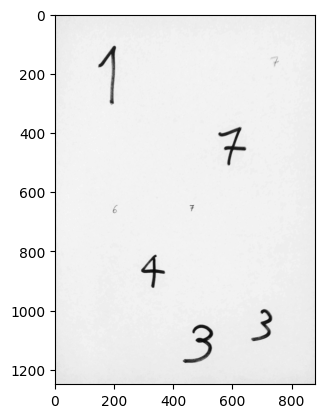

In [24]:
def find_perspective_transform(imgs_intersections):
    transformed_images = []
    for img_index, intersections in enumerate(imgs_intersections):
        if len(intersections) < 4:
            print("Not enough intersection points found")
            continue
            
        w, h = 880, 1250  # we assume 10 pixels per mm
        A = np.array([0, h])
        B = np.array([w, h])
        C = np.array([w, 0])
        D = np.array([0, 0])

        # from homogeneous to cartesian
        dst = [
            np.array([intersections[0][0] / intersections[0][2], intersections[0][1] / intersections[0][2]]),
            np.array([intersections[1][0] / intersections[1][2], intersections[1][1] / intersections[1][2]]),
            np.array([intersections[2][0] / intersections[2][2], intersections[2][1] / intersections[2][2]]),
            np.array([intersections[3][0] / intersections[3][2], intersections[3][1] / intersections[3][2]])
        ]
        # sort dst by x
        top_points = sorted(dst, key=lambda y: y[1])[0:2]
        bottom_points = sorted(dst, key=lambda y: y[1])[2:4]
        # sort dst by y

        dst = sorted(bottom_points, key=lambda x: x[0]) + sorted(top_points, key=lambda x: x[0])[::-1]

        invtf = skimage.transform.estimate_transform("projective", src=np.vstack((A, B, C, D)), dst=np.vstack(dst))
        tim = skimage.transform.warp(image=images[img_index], inverse_map=invtf, output_shape=(h, w))
        transformed_images.append(tim)
    return transformed_images

transformed_images = find_perspective_transform(imgs_intersections)

In [26]:
# plot transformed images
@widgets.interact(image_index=(0, len(images) - 1, 1))
def plot_images(image_index=7):
    plt.imshow(transformed_images[image_index], cmap="gray")

interactive(children=(IntSlider(value=7, description='image_index', max=20), Output()), _dom_classes=('widget-…